# Day 2: Natural Language Processing

### Set up the environment

In [1]:
# Imports for files and data handling
import numpy as np
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile
import textwrap
from IPython.display import display, Markdown

# Imports for methods and models
import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import transformers
from transformers import (
    AutoTokenizer,
    TextStreamer,
)

# Set random seed for reproducibility
np.random.seed(47176870)

### Download and inspect the textual data (speeches)

Bundesbank Speeches (bbk_speeches) is a text based dataset, entailing the speeches of current and past members of the executive board of the Deutsche Bundesbank beginning in January 2012 until December 2017. It compromises publicly available information in the press area of the Deutsche Bundesbank's website, which is further cleaned and enhanced by publicly available information on the respective speakers. 

More information: https://www.bundesbank.de/en/bundesbank/research/rdsc/research-data/bundesbank-speeches-812362

In [2]:
# Download the speeches data
get_speeches = requests.get(
    "https://www.bundesbank.de/resource/blob/812360/cfe0f9d8907bffe7bb76dd3b0e4c866a/mL/bbk-speeches-data.zip"
)
get_speeches.raise_for_status()

In [3]:
# Open the zip file from the downloaded content
speeches_zip_file = ZipFile(BytesIO(get_speeches.content))

# Read the CSV file from the zip file
df_speeches = pd.read_csv(
    speeches_zip_file.open("2019-09-20_BBkSpeeches.csv"),
    sep=";",
)

In [4]:
# Check the variables in the data set
df_speeches.columns

Index(['spch_id', 'spkr_surname', 'spkr_first_name', 'spch_datetime',
       'spch_title', 'spch_occasion', 'spch_loc', 'spch_lang', 'spch_sec_num',
       'spch_sec_title', 'spch_sec_body', 'spkr_titles', 'spkr_gender',
       'spkr_bbk_role', 'spkr_phd', 'spkr_major', 'spkr_apprenticeship',
       'spkr_phd_univ', 'spkr_nom_pol_body', 'spkr_nom_pol_geo',
       'spkr_nom_pol_party', 'spkr_pers_party', 'spkr_birthplace',
       'spkr_birth_year', 'spkr_birth_month', 'spkr_bbk_start', 'spkr_bbk_end',
       'spkr_bbk_dismissed'],
      dtype='object')

In [5]:
# Summarize the data using pandas
df_speeches.describe(include="all")

,spch_id,spkr_surname,spkr_first_name,spch_datetime,spch_title,spch_occasion,spch_loc,spch_lang,spch_sec_num,spch_sec_title,...,spkr_nom_pol_body,spkr_nom_pol_geo,spkr_nom_pol_party,spkr_pers_party,spkr_birthplace,spkr_birth_year,spkr_birth_month,spkr_bbk_start,spkr_bbk_end,spkr_bbk_dismissed
count,3672,3672,3672,3672,3672,3467,3672,3672,3672.000000,3578,...,3672,1902,2104,3672,3672,3672.000000,3672.000000,3672,2138,3672
unique,791,9,8,597,768,714,134,4,NaN,2233,...,2,5,7,6,8,NaN,NaN,8,4,1
top,20150309T183000_Weidmann_en,Dombret,Andreas Raymond,25.11.2014T11:00:00+0100,Welcome remarks,Forum Bundesbank,Frankfurt am Main,de,NaN,Introduction,...,Council,"Hamburg, Mecklenburg-Vorpommern, Schleswig-Hol...","CDU/CSU, SPD",CDU,"Des Moines, USA",NaN,NaN,2010-05-01,2018-04-30,False
freq,13,1568,1568,22,20,21,1236,1870,NaN,280,...,1902,1568,1390,1601,1568,NaN,NaN,1948,1948,3672
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.130719,NaN,...,NaN,NaN,NaN,NaN,NaN,1962.413943,3.297930,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.722609,NaN,...,NaN,NaN,NaN,NaN,NaN,4.905836,2.408334,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1946.000000,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1960.000000,1.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1960.000000,4.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1968.000000,4.000000,NaN,NaN,NaN


In [6]:
# Check the first 5 rows of speeches data
df_speeches.head(5)

,spch_id,spkr_surname,spkr_first_name,spch_datetime,spch_title,spch_occasion,spch_loc,spch_lang,spch_sec_num,spch_sec_title,...,spkr_nom_pol_body,spkr_nom_pol_geo,spkr_nom_pol_party,spkr_pers_party,spkr_birthplace,spkr_birth_year,spkr_birth_month,spkr_bbk_start,spkr_bbk_end,spkr_bbk_dismissed
0,20120117T191000_Thiele_de,Thiele,Carl-Ludwig,17.01.2012T19:10:00+0100,SEPA-Umsetzung in Deutschland & Europa – die S...,Vortrag auf dem Omnicard-Kongress,Berlin,de,1,Einleitung,...,Government,NaN,"CDU/CSU, FDP",FDP,Münster,1953,8,2010-05-01,2018-04-30,False
1,20120117T191000_Thiele_de,Thiele,Carl-Ludwig,17.01.2012T19:10:00+0100,SEPA-Umsetzung in Deutschland & Europa – die S...,Vortrag auf dem Omnicard-Kongress,Berlin,de,2,Nachholbedarf bei der SEPA-Migration,...,Government,NaN,"CDU/CSU, FDP",FDP,Münster,1953,8,2010-05-01,2018-04-30,False
2,20120117T191000_Thiele_de,Thiele,Carl-Ludwig,17.01.2012T19:10:00+0100,SEPA-Umsetzung in Deutschland & Europa – die S...,Vortrag auf dem Omnicard-Kongress,Berlin,de,3,Regulierung mit Augenmaß,...,Government,NaN,"CDU/CSU, FDP",FDP,Münster,1953,8,2010-05-01,2018-04-30,False
3,20120117T191000_Thiele_de,Thiele,Carl-Ludwig,17.01.2012T19:10:00+0100,SEPA-Umsetzung in Deutschland & Europa – die S...,Vortrag auf dem Omnicard-Kongress,Berlin,de,4,Kundenfreundliche Umstellung entscheidend,...,Government,NaN,"CDU/CSU, FDP",FDP,Münster,1953,8,2010-05-01,2018-04-30,False
4,20120117T191000_Thiele_de,Thiele,Carl-Ludwig,17.01.2012T19:10:00+0100,SEPA-Umsetzung in Deutschland & Europa – die S...,Vortrag auf dem Omnicard-Kongress,Berlin,de,5,Ausbau der Verfahren weiterhin nötig,...,Government,NaN,"CDU/CSU, FDP",FDP,Münster,1953,8,2010-05-01,2018-04-30,False


In [7]:
# Filter only the English speeches that are not introductions
idx_en = df_speeches.spch_lang == "en"
idx_not_intro = df_speeches.spch_sec_title != "Introduction"
english_speeches = df_speeches[idx_en & idx_not_intro]
print(f"Number of filtered speeches: {len(english_speeches)}")

Number of filtered speeches: 1458


In [8]:
# Select a random row from the filtered speeches and display it
random_row_index = np.random.randint(0, len(english_speeches))
print(f"{random_row_index=}")

random_speech_section = english_speeches.iloc[random_row_index]
random_speech_body = random_speech_section.spch_sec_body

display(random_speech_section)
display(Markdown(textwrap.fill(random_speech_body, width=50)))

random_row_index=1218


spch_id                                       20171117T193000_Dombret_en
spkr_surname                                                     Dombret
spkr_first_name                                          Andreas Raymond
spch_datetime                                   17.11.2017T19:30:00+0100
spch_title             Why business needs values – what we can learn ...
spch_occasion              Speech delivered at Academie Kloster Eberbach
spch_loc                                               Eltville am Rhein
spch_lang                                                             en
spch_sec_num                                                           2
spch_sec_title                 What we can learn from the banking sector
spch_sec_body          Why exactly does business need values? After a...
spkr_titles                                                          Dr.
spkr_gender                                                         male
spkr_bbk_role                                      

Why exactly does business need values? After all,
it’s perfectly adequate for the market to be
guided by the invisible hand of competition – at
least that was the predominant view before the
financial crisis struck. There is no lack of
controversial views claiming that business and
ethics are locked in eternal conflict. US investor
George Soros, for instance, once said that the
profit-maximising behaviour characteristic
“ignores the demands of morality”, thereby
rendering financial markets amoral rather than
immoral. Following Mr Soros’ line of thinking,
then, perhaps we don’t actually need any values at
all in business? Isn’t “competition”, in and of
itself, enough of a value for business? But scour
the banking sector and you will find instances
where ethics sometimes only played second fiddle,
paving the way for what was, at times, glaring
misconduct. The financial crisis, which originated
in the US real estate markets in 2007, is a lesson
that the consequences of pushing for short-term
profits can be catastrophic. Bankers who were
convinced that their securitisation vehicles had
shifted credit risk off their books let their
conservative lending standards slip, which meant,
in a nutshell, that they ended up issuing and
securitising far too many risky loans. In a second
step, those bankers underestimated the possibility
that those loans might default because of a lack
of due care and also the opacity of those
securitised products. Compensation models
rewarding short-term behaviour did the rest. This
all set a cycle of events in motion in which loans
were systematically granted to customers who were
unable to service them. Not just that: in some
cases, customers were deliberately mis-sold loans,
all in the interest of pocketing quick gains. It's
hardly surprising, then, that the crash in the US
real estate market proved to have very far-
reaching implications, not least in the shape of
enormous costs for banks and a loss of confidence.
The court rulings, fines and customer exodus I
mentioned earlier thus continued to take their
toll on banks long after the US real estate market
went into free-fall. Bearing all this in mind, one
could be forgiven for thinking that it was
unethical behaviour which made the financial
crisis possible in the first place. Financial mis-
selling and a focus on short-term profitability
were rewarded, securitisation encouraged opaque
and dishonest conduct, and there was no such thing
as a realistic assessment of credit risk. There’s
another example I could mention to show that the
market is incapable of regulating itself and that
values, it would appear, still haven’t made an
appearance in some quarters of the banking
industry. I’m talking about the Libor scandal –
that is, the rigging of the benchmark London
interbank offered rate. Bankers colluded to submit
fictitious interest rates so as to falsely inflate
or deflate Libor. This rigged rate then fed into
financial transactions all around the world; many
credit or savings products are geared to the Libor
benchmark rate. So if you ask me whether business
needs ethical values, the answer is an unequivocal
and resounding yes. And as for the other question
I asked just now, my answer would be a definite
no. Competition, in and of itself, isn’t enough;
we need rules to stake out a clear operational
framework. Leaving the market to its own devices
isn't an option. But the question is whether we
can achieve this simply with rules and
supervision? Many a new approach in the world of
banking supervision is designed to do just that,
but if there’s one thing I can tell you already,
it is that they will never go far enough. Because
when it comes down to it, values are beliefs which
each and every one of us needs to anchor in our
own behaviour. And that is precisely the problem
which I intend to delve into later in my speech to
you today.

### Download and experiment with a pre-trained model

We will work with the "t5-small" variant of the model T5 (Text-To-Text Transfer Transformer) developed by Google researchers, downloaded from the platform Hugging Face.

**Quick facts:**
- T5 is based a **transformer** architecture, which is widely used in natural language processing (NLP) tasks. It consists of an encoder-decoder structure.
- T5 is trained for **text-to-text problems**, so input and output are always text strings.
- T5 can be **fine-tuned** on specific tasks such as translation, summarization, question answering, and more by providing task-specific input-output pairs.
- T5 comes in **several sizes**. To limit the required computational resources, we will use the smallest size for demonstration in this course.

The pre-trained model is available under https://huggingface.co/google-t5/t5-small

**Publication:** Raffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., ... & Liu, P. J. (2020). Exploring the limits of transfer learning with a unified text-to-text transformer. Journal of machine learning research, 21(140), 1-67. https://jmlr.org/papers/volume21/20-074/20-074.pdf

In [9]:
# Set the model name to extract from the Hugging Face model hub using the transformers library
model_name = "google-t5/t5-small"

model = transformers.T5ForConditionalGeneration.from_pretrained(
    model_name,
    # device_map="auto", # automatically distributes the model's layers across all available devices
)

# Check how many parameters the model has
print(f"Model Parameter count: {model.num_parameters():,}")

Model Parameter count: 60,506,624


In [10]:
# Use the tokenizer from the T5 model
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    # pad to ensure that all sequences in a batch have the same length.
    # Left padding is often used in sequence-to-sequence tasks (learn positional dependencies)
    padding_side="left",
)

streamer = TextStreamer(tokenizer)

#  Return the items of the tokenizer's vocabulary sorted by their index
vocab = dict(
    (v, k) for k, v in sorted(tokenizer.vocab.items(), key=lambda kv_pair: kv_pair[1])
)

# Maximum token length
print(f"Maximum token length: {tokenizer.model_max_length}")

Maximum token length: 512


In [11]:
# Tokenize the randomly selected speech body to summarize it (i.e., map the input text to the model's vocabulary)
input_ids = tokenizer(
    f"summarize: {random_speech_body}",  # input text and summarize command
    truncation=True,  # truncate the input if it is longer than the maximum token length of the model
    return_tensors="pt",  # convert output in pytorch tensors
).input_ids

In [12]:
# Compare the input text with the tokenized input

indices = input_ids[0, 0:20].tolist()
display(indices)  # Indices of the tokenized input in the model's vocabulary
display(
    [vocab[idx] for idx in indices]
)  # "Words" corresponding to the indices in the model's vocabulary - note that at least one is cut out (why?)
display(random_speech_body.split()[:15])  # actual words in the input text

[21603,
 10,
 1615,
 1776,
 405,
 268,
 174,
 2620,
 58,
 621,
 66,
 6,
 34,
 22,
 7,
 3923,
 9289,
 21,
 8,
 512]

['▁summarize',
 ':',
 '▁Why',
 '▁exactly',
 '▁does',
 '▁business',
 '▁need',
 '▁values',
 '?',
 '▁After',
 '▁all',
 ',',
 '▁it',
 '’',
 's',
 '▁perfectly',
 '▁adequate',
 '▁for',
 '▁the',
 '▁market']

['Why',
 'exactly',
 'does',
 'business',
 'need',
 'values?',
 'After',
 'all,',
 'it’s',
 'perfectly',
 'adequate',
 'for',
 'the',
 'market',
 'to']

In [13]:
# Compare the original input text length with the tokenized input length
display(len(random_speech_body.split()))  # original input text
display(len(input_ids[0]))  # tokenized input

642

512

In [14]:
# "Re-created" version of the input text (summary of the randomly selected speech body) - will be cut at 512 tokens (!)
display(Markdown(textwrap.fill(tokenizer.decode(input_ids[0]), width=50)))

summarize: Why exactly does business need values?
After all, it’s perfectly adequate for the market
to be guided by the invisible hand of competition
– at least that was the predominant view before
the financial crisis struck. There is no lack of
controversial views claiming that business and
ethics are locked in eternal conflict. US investor
George Soros, for instance, once said that the
profit-maximising behaviour characteristic
“ignores the demands of morality”, thereby
rendering financial markets amoral rather than
immoral. Following Mr Soros’ line of thinking,
then, perhaps we don’t actually need any values at
all in business? Isn’t “competition”, in and of
itself, enough of a value for business? But scour
the banking sector and you will find instances
where ethics sometimes only played second fiddle,
paving the way for what was, at times, glaring
misconduct. The financial crisis, which originated
in the US real estate markets in 2007, is a lesson
that the consequences of pushing for short-term
profits can be catastrophic. Bankers who were
convinced that their securitisation vehicles had
shifted credit risk off their books let their
conservative lending standards slip, which meant,
in a nutshell, that they ended up issuing and
securitising far too many risky loans. In a second
step, those bankers underestimated the possibility
that those loans might default because of a lack
of due care and also the opacity of those
securitised products. Compensation models
rewarding short-term behaviour did the rest. This
all set a cycle of events in motion in which loans
were systematically granted to customers who were
unable to service them. Not just that: in some
cases, customers were deliberately mis-sold loans,
all in the interest of pocketing quick gains. It's
hardly surprising, then, that the crash in the US
real estate market proved to have very far-
reaching implications, not least in the shape of
enormous costs for banks and a loss of confidence.
The court rulings, fines and customer exodus I
mentioned earlier thus continued to take their
toll on banks long after the US real estate market
went into free-fall. Bearing all this in mind, one
could be forgiven for thinking that it was
unethical behaviour which made the financial
crisis possible in the first place. Financial mis-
selling and a focus on short-term profitability
were </s>

### Inference step

In [15]:
outputs = model.generate(
    input_ids,
    max_new_tokens=500,
    streamer=streamer,
    do_sample=False,  # no sampling
)

# tokenizer.decode(outputs[0], skip_special_tokens=True)

<pad> a spokesman for the bank says the financial crisis is a 'failure of morality'  the financial crisis originated in the US real estate markets in 2007  the consequences of pushing for short-term profits can be catastrophic </s>


In [16]:
for _ in range(5):
    model.generate(
        input_ids,
        max_new_tokens=500,
        streamer=streamer,
        do_sample=True,  # now with sampling
        top_k=50,  # sample from the top 50 most likely tokens
    )
    print()

<pad> the economic crisis (financial markets) started in the 7th year of 2007  but business and ethics were locked in eternal conflict until the crisis  there were many times moments when financial markets failed to have values  some of the biggest risks faced by the crisis are a lack of a value </s>

<pad> bankers in the banking sector have warned the 'distracted' consequences of short-term profits  financial crisis blamed one step on risky loans rather than an issue  now bankers have stepped up or securitised risky loans to keep company going </s>

<pad> british investors have challenged business ethical policies  ethical policies often use second fiddle to make money  crisis means profits that fall and take risks </s>

<pad> the financial crisis originated in the US real estate markets in 2007  but april 17 led to the crash of the real estate market in the mid 2000s  the bankers underestimated that financial risk  also, bankers were deliberately mis-sold loans, all in the interest o

In [17]:
# Create a function to generate predictions for the next token
def show_next_token_predictions(prompt, temperature=None, n=20, cuda=False, top_p=None):
    model_inputs = tokenizer(prompt, truncation=True, return_tensors="pt")
    if cuda:
        model_inputs = model_inputs.to("cuda")
    generated_outputs = model.generate(
        **model_inputs,
        max_new_tokens=1,  # how many tokens to generate (here: just one)
        do_sample=True,  # sample for more diverse outputs
        num_return_sequences=1,  # how many sequences to return
        output_scores=True,  # return scores for understanding the model's confidence
        output_logits=True,  # return the raw scores
        return_dict_in_generate=True,  # return a dictionary with the generated output
        temperature=temperature,  # scales the logits before applying the softmax function
        top_p=top_p,  # only suggest the top tokens that cumulatively have probability p, preventing unlikely flukes
    )
    scores = generated_outputs.scores[0][0]
    logits = generated_outputs.logits[0][0]
    probabilities = F.softmax(scores, dim=0)
    top_scores, top_indices = torch.topk(scores, n)
    print(
        f"| {'id':^5s} | {'token':^12s} | {'logit':^7s} | {'score':^7s} | {'prob':^6s} |"
    )
    for score, index in zip(top_scores, top_indices):
        token = vocab[int(index)]
        logit = logits[index]
        prob = probabilities[index]
        if prob < 0.0001:
            break
        print(
            f"| {index:5d} | {token:12s} | {logit:7.4f} | {score:7.4f} | {prob:.4f} |"
        )

In [18]:
# Apply the function to the randomly selected speech body
show_next_token_predictions(f"summarize: {random_speech_body}")

|  id   |    token     |  logit  |  score  |  prob  |
|     3 | ▁            | -2.5202 | -2.5202 | 0.2363 |
|     8 | ▁the         | -3.0680 | -3.0680 | 0.1366 |
|  4367 | ▁investors   | -3.6328 | -3.6328 | 0.0777 |
|   981 | ▁financial   | -3.8187 | -3.8187 | 0.0645 |
|   268 | ▁business    | -4.1889 | -4.1889 | 0.0445 |
| 12024 | ▁investor    | -4.5129 | -4.5129 | 0.0322 |
|  1456 | ▁economic    | -4.7463 | -4.7463 | 0.0255 |
| 20163 | ▁economist   | -4.7540 | -4.7540 | 0.0253 |
|  5028 | ▁banks       | -4.8002 | -4.8002 | 0.0242 |
|    16 | ▁in          | -4.9618 | -4.9618 | 0.0206 |
|  2137 | ▁bank        | -4.9940 | -4.9940 | 0.0199 |
| 11398 | ▁ethical     | -5.0723 | -5.0723 | 0.0184 |
| 10211 | ▁american    | -5.1079 | -5.1079 | 0.0178 |
|    34 | ▁it          | -5.1080 | -5.1080 | 0.0178 |
|   128 | ▁some        | -5.2218 | -5.2218 | 0.0159 |
|   132 | ▁there       | -5.2567 | -5.2567 | 0.0153 |
| 16083 | ▁ethics      | -5.4725 | -5.4725 | 0.0123 |
|  1729 | ▁investment  | -5.

In [19]:
# Use a lower temperature to generate more deterministic predictions
# (sample the most probable tokens - may become more focused, but also more repetitive)
show_next_token_predictions(f"summarize: {random_speech_body}", temperature=0.1)

|  id   |    token     |  logit  |  score  |  prob  |
|     3 | ▁            | -2.5202 | -25.2025 | 0.9958 |
|     8 | ▁the         | -3.0680 | -30.6805 | 0.0042 |


In [20]:
# Increase the temperature to generate more diverse predictions
# (sample from a wider range of tokens - may become more creative, but also more chaotic)
show_next_token_predictions(f"summarize: {random_speech_body}", temperature=50.0)

|  id   |    token     |  logit  |  score  |  prob  |
|     3 | ▁            | -2.5202 | -0.0504 | 0.0213 |
|     8 | ▁the         | -3.0680 | -0.0614 | 0.0211 |
|  4367 | ▁investors   | -3.6328 | -0.0727 | 0.0208 |
|   981 | ▁financial   | -3.8187 | -0.0764 | 0.0208 |
|   268 | ▁business    | -4.1889 | -0.0838 | 0.0206 |
| 12024 | ▁investor    | -4.5129 | -0.0903 | 0.0205 |
|  1456 | ▁economic    | -4.7463 | -0.0949 | 0.0204 |
| 20163 | ▁economist   | -4.7540 | -0.0951 | 0.0204 |
|  5028 | ▁banks       | -4.8002 | -0.0960 | 0.0203 |
|    16 | ▁in          | -4.9618 | -0.0992 | 0.0203 |
|  2137 | ▁bank        | -4.9940 | -0.0999 | 0.0203 |
| 11398 | ▁ethical     | -5.0723 | -0.1014 | 0.0202 |
| 10211 | ▁american    | -5.1079 | -0.1022 | 0.0202 |
|    34 | ▁it          | -5.1080 | -0.1022 | 0.0202 |
|   128 | ▁some        | -5.2218 | -0.1044 | 0.0202 |
|   132 | ▁there       | -5.2567 | -0.1051 | 0.0202 |
| 16083 | ▁ethics      | -5.4725 | -0.1094 | 0.0201 |
|  1729 | ▁investment  | -5.

In [21]:
# Only consider the most likely continuations, setting everything else to 0%
# (hopefully striking a balance between reasonable and non-stale results)
show_next_token_predictions(f"summarize: {random_speech_body}", top_p=0.70)

|  id   |    token     |  logit  |  score  |  prob  |
|     3 | ▁            | -2.5202 | -2.5202 | 0.3341 |
|     8 | ▁the         | -3.0680 | -3.0680 | 0.1932 |
|  4367 | ▁investors   | -3.6328 | -3.6328 | 0.1098 |
|   981 | ▁financial   | -3.8187 | -3.8187 | 0.0912 |
|   268 | ▁business    | -4.1889 | -4.1889 | 0.0630 |
| 12024 | ▁investor    | -4.5129 | -4.5129 | 0.0455 |
|  1456 | ▁economic    | -4.7463 | -4.7463 | 0.0361 |
| 20163 | ▁economist   | -4.7540 | -4.7540 | 0.0358 |
|  5028 | ▁banks       | -4.8002 | -4.8002 | 0.0342 |
|    16 | ▁in          | -4.9618 | -4.9618 | 0.0291 |
|  2137 | ▁bank        | -4.9940 | -4.9940 | 0.0282 |


In [22]:
def show_transition_probabilities(
    prompt, max_new_tokens=100, temperature=None, cuda=False
):
    model_inputs = tokenizer(prompt, truncation=True, return_tensors="pt")
    if cuda:
        model_inputs = model_inputs.to("cuda")
    generated_outputs = model.generate(
        **model_inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        num_return_sequences=1,
        output_scores=True,
        output_logits=True,
        return_dict_in_generate=True,
        temperature=temperature,
        streamer=streamer,
    )
    input_length = model_inputs["input_ids"].shape[1]
    generated_tokens = generated_outputs.sequences  # [:, input_length:]
    transition_scores = model.compute_transition_scores(
        generated_outputs.sequences,
        generated_outputs.scores,
        normalize_logits=True,
    )
    print(f"| {'id':^5s} | {'token':^12s} | {'logits':^7s} | {'probability':^5s}")
    for tok, score in zip(generated_tokens[0], transition_scores[0]):
        print(
            f"| {tok:5d} | {repr(vocab[int(tok)]):12s} | {score.cpu():.4f} | {np.exp(score.cpu()):.2%}"
        )


In [23]:
show_transition_probabilities(f"summarize: {random_speech_body}", temperature=1.0)

<pad> bankers who first saw an investor get a job ignoring a huge risk  business and morality were under threat of financial fraud from 2007  however some think business had an unfair advantage as the financial crisis struck  a legal action against the bank did nothing but provide valuable valuations </s>
|  id   |    token     | logits  | probability
|     0 | '<pad>'      | -3.9166 | 1.99%
|  2137 | '▁bank'      | -0.0689 | 93.34%
|   277 | 'ers'        | -0.7277 | 48.30%
|   113 | '▁who'       | -5.9583 | 0.26%
|   166 | '▁first'     | -2.4324 | 8.78%
|  1509 | '▁saw'       | -5.1683 | 0.57%
|    46 | '▁an'        | -4.0661 | 1.71%
| 12024 | '▁investor'  | -4.2237 | 1.46%
|   129 | '▁get'       | -1.4304 | 23.92%
|     3 | '▁'          | -0.1499 | 86.08%
|     9 | 'a'          | -2.6456 | 7.10%
|   613 | '▁job'       | -2.3769 | 9.28%
|     3 | '▁'          | -3.5049 | 3.01%
| 25975 | 'ignoring'   | -2.4650 | 8.50%
|     3 | '▁'          | -0.2618 | 76.97%
|     9 | 'a'          | -

In [24]:
show_transition_probabilities(f"summarize: {random_speech_body}", temperature=0.01)

<pad> a spokesman for the bank says the financial crisis is a 'failure'  the financial crisis originated in the US real estate markets in 2007  the financial crisis is a lesson that the consequences of pushing for short-term profits can be catastrophic </s>
|  id   |    token     | logits  | probability
|     0 | '<pad>'      | 0.0000 | 100.00%
|     3 | '▁'          | 0.0000 | 100.00%
|     9 | 'a'          | 0.0000 | 100.00%
|     3 | '▁'          | 0.0000 | 100.00%
|     7 | 's'          | 0.0000 | 100.00%
| 18461 | 'pokesman'   | 0.0000 | 100.00%
|    21 | '▁for'       | 0.0000 | 100.00%
|     8 | '▁the'       | 0.0000 | 100.00%
|  2137 | '▁bank'      | 0.0000 | 100.00%
|   845 | '▁says'      | -0.0008 | 99.92%
|     8 | '▁the'       | 0.0000 | 100.00%
|   981 | '▁financial' | 0.0000 | 100.00%
|  5362 | '▁crisis'    | 0.0000 | 100.00%
|    19 | '▁is'        | 0.0000 | 100.00%
|     3 | '▁'          | 0.0000 | 100.00%
|     9 | 'a'          | 0.0000 | 100.00%
|     3 | '▁'          

In [25]:
show_transition_probabilities(f"summarize: {random_speech_body}", temperature=50.0)

<pad> money makers in 2013 used this knowledge of the finance economy which could hurt society but still become part from economy, industry professionals. this became evident following sojournam who found themselves unawarely about investing (most certainly), even financially void of profit after taking action when delaying repayment obligations abroad over time and saving them on risk with banks (just in case: in many financial instances and people  this had prompted such speculation). with no further problems within both public banks on twitter, investors and
|  id   |    token     | logits  | probability
|     0 | '<pad>'      | -3.9175 | 1.99%
|   540 | '▁money'     | -3.9315 | 1.96%
| 13730 | '▁makers'    | -3.8958 | 2.03%
|    16 | '▁in'        | -3.9233 | 1.98%
|  2038 | '▁2013'      | -3.9037 | 2.02%
|   261 | '▁used'      | -3.9133 | 2.00%
|    48 | '▁this'      | -3.9104 | 2.00%
|  1103 | '▁knowledge' | -3.8557 | 2.12%
|    13 | '▁of'        | -3.8411 | 2.15%
|     8 | '▁the'

In [26]:
input_ids = tokenizer(
    f"analyse sentiment: {random_speech_body}",
    truncation=True,
    return_tensors="pt",
).input_ids
outputs = model.generate(
    input_ids,
    max_new_tokens=100,
    streamer=streamer,
    do_sample=True,
)

<pad><extra_id_0> that it’s a lesson that ethical behaviour made the situation possible  a fundamental understanding in business and ethics, a key concern, says analyst  "we need those values at all in business," he says </s>


### Sentiment Analysis

T5 was also trained on the Stanford Sentiment Treebank (SST2) data set (https://paperswithcode.com/dataset/sst), so we can use it "out-of-the-box" for sentiment classification. 
However, because T5 is a text-to-text model, without further adaptation we will obtain a label, but no predicted probabilities.

In [27]:
# Test with a sample sentence
sentence = "After all, it’s perfectly adequate for the market to be guided by the invisible hand of competition, at least that was the predominant view before the financial crisis struck."

input_ids = tokenizer(
    f"sst2 sentence: {sentence}",  # prefix for the sentiment analysis task
    truncation=True,
    return_tensors="pt",
).input_ids
outputs = model.generate(
    input_ids,
    max_new_tokens=100,
    streamer=streamer,
    do_sample=True,
)

<pad> positive</s>


In [28]:
# Test with the randomly selected speech body
input_ids = tokenizer(
    f"sst2 sentence: {random_speech_body}",  # prefix for the sentiment analysis task
    truncation=True,
    return_tensors="pt",
).input_ids
outputs = model.generate(
    input_ids,
    max_new_tokens=100,
    streamer=streamer,
    do_sample=True,
)

<pad> negative</s>


In [29]:
# Under the hood it is still merely next token prediction
show_next_token_predictions(f"sst2 sentence: {random_speech_body}", top_p=0.999)

|  id   |    token     |  logit  |  score  |  prob  |
|  2841 | ▁negative    | -2.9270 | -2.9270 | 0.8545 |
|  1465 | ▁positive    | -4.7003 | -4.7003 | 0.1451 |
|    59 | ▁not         | -11.1129 | -11.1129 | 0.0002 |
| 29452 | ▁unacceptable | -11.4156 | -11.4156 | 0.0002 |


In [30]:
# Classify the sentiment of several bodies

# Define a function to classify the sentiment of a given text
def classify_sentiment_t5(text):
    input_ids = tokenizer(
        f"sst2 sentence: {text}",  # prefix for the sentiment analysis task
        truncation=True,
        return_tensors="pt",
    ).input_ids
    outputs = model.generate(
        input_ids,
        max_new_tokens=100,
        do_sample=True,
    )
    sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return sentiment

In [31]:
# Apply the function to the first 100 speech bodies and store the result in a new column
batch = english_speeches.sample(n=100)
batch["sentiment"] = batch["spch_sec_body"].apply(classify_sentiment_t5)

### Plot the Sentiment over Time

In [32]:
# Convert 'spch_datetime' to datetime format and sort by datetime
batch["spch_datetime"] = pd.to_datetime(
    batch["spch_datetime"], format="%d.%m.%YT%H:%M:%S%z", errors="coerce", utc=True
)
batch = batch.sort_values(by="spch_datetime")
batch["year"] = batch["spch_datetime"].dt.year

# Map sentiment values to numerical values
sentiment_mapping = {"positive": 1, "negative": -1}
batch["sentiment_numeric"] = batch["sentiment"].map(sentiment_mapping)

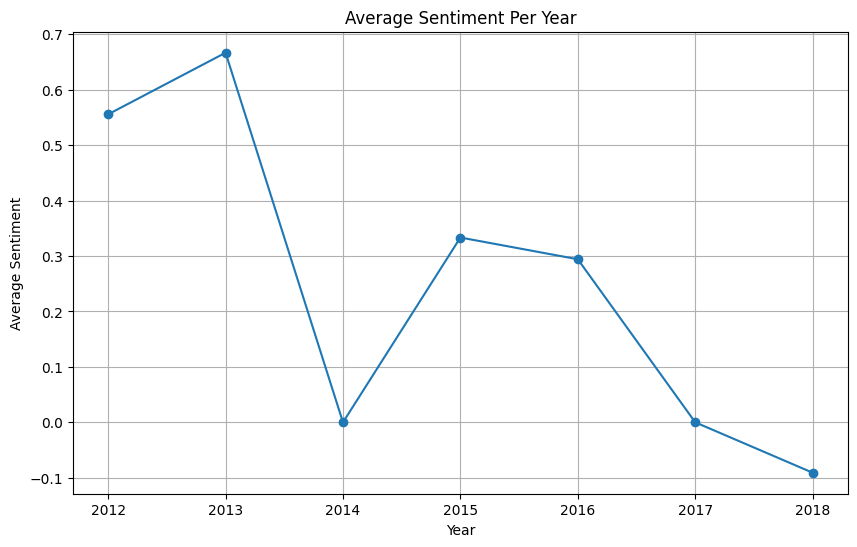

In [33]:
# Calculate average per year
avg_sent_year = batch.groupby("year")["sentiment_numeric"].mean().reset_index()

# Plot the sentiment over time
plt.figure(figsize=(10, 6))
plt.plot(
    avg_sent_year["year"], avg_sent_year["sentiment_numeric"], marker="o", linestyle="-"
)
plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment Per Year")
plt.grid(True)
plt.show()

### The start of Transfer Learning

In [6]:
# We reload the bare model without the final next-token-predictor head

headless_model = transformers.T5Model.from_pretrained(
    model_name,
    device_map="auto",
)

In [15]:
# This time we are not applying a transformation function to many texts
# Instead we are applying the call only once to a single batch of texts
batch_size = 500
sample = df_speeches.sample(n=batch_size)
batch = list(sample.spch_sec_body.values)

input_ids = tokenizer(
    batch,
    truncation=True,
    padding=True,
    pad_to_multiple_of=tokenizer.model_max_length,  # For our later analysis we want everything to have the same shape
    return_tensors="pt",
).input_ids

In [16]:
# When directly calling the transformer architecture, we need to provide both
# "Input" tokens (like a question, or instruction)
# and "Decoder Input" Tokens (which are to be generated by the model one by one)

# We only want a representation of the input string
# Therefore the "decoder Inputs" can be barebones, just a single start pad token
decoder_input_ids = torch.zeros(batch_size, 1, dtype=int)

In [17]:
# This time we don't care about the output, we are interested in the last representation layer
outputs = headless_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
last_hidden_states = outputs.last_hidden_state
display(last_hidden_states.shape)

torch.Size([500, 1, 512])

In [18]:
# We do some rearranging to get the hidden state into matrix form per text
np_last_hidden_states = last_hidden_states.detach().numpy().squeeze(1)
display(np_last_hidden_states.shape)

(500, 512)

In [19]:
# Looking directly: Somewhat smaller inscrutable matrix of floating point numbers
display(last_hidden_states)

tensor([[[ 2.5201e-02,  1.6209e-01,  5.1306e-02,  ...,  6.3182e-03,
           8.7969e-04, -9.4234e-02]],

        [[ 3.7659e-02,  1.8263e-01,  5.3657e-02,  ..., -1.8364e-02,
           9.7022e-04, -8.3324e-02]],

        [[ 2.4930e-02,  1.3117e-01,  5.5311e-02,  ..., -1.1700e-02,
           5.9118e-04, -1.2311e-01]],

        ...,

        [[ 2.6857e-02,  1.9398e-01,  7.0278e-03,  ..., -2.9001e-02,
           1.7876e-04, -8.9838e-02]],

        [[ 5.6524e-02,  1.5804e-01, -6.1725e-03,  ..., -1.2722e-02,
           4.0042e-05, -7.4266e-02]],

        [[ 3.6314e-02,  6.9370e-02,  1.8349e-02,  ..., -2.7775e-02,
           2.9270e-04, -1.5683e-02]]], grad_fn=<MulBackward0>)

In [20]:
# We use the TSNE tool to visualize this in 2d plots
# This embedding is designed to keep similar points closeby
tsne = sklearn.manifold.TSNE()
Xt = tsne.fit_transform(np_last_hidden_states)

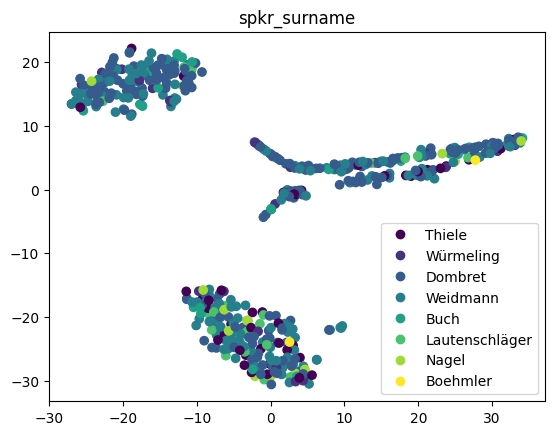

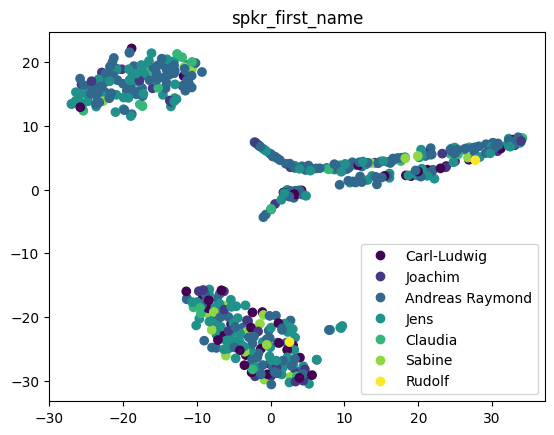

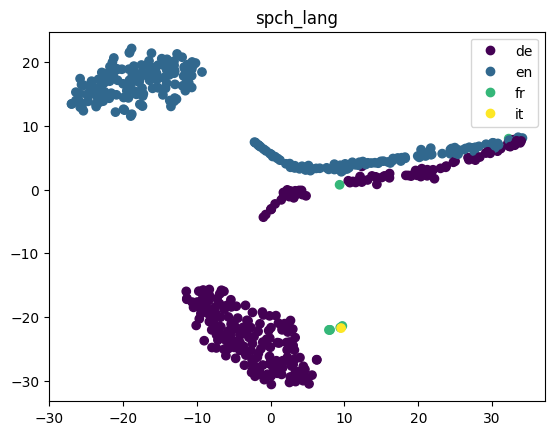

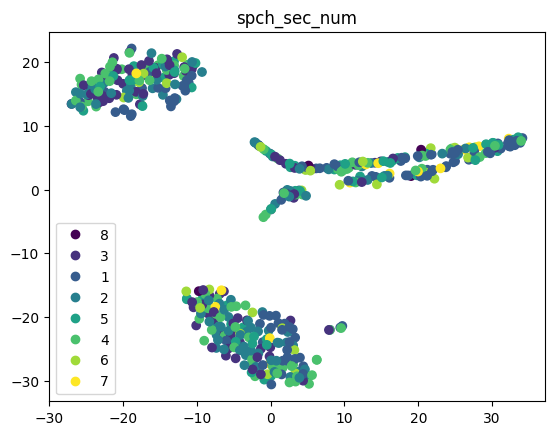

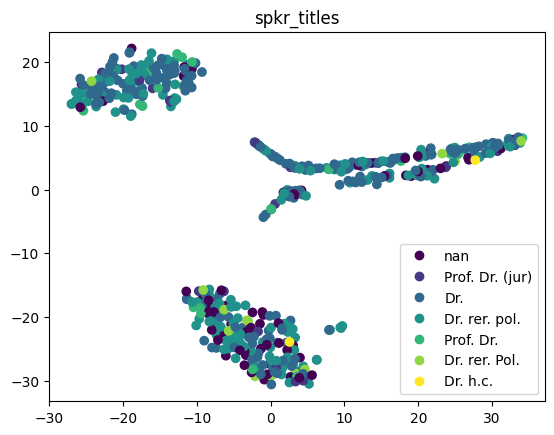

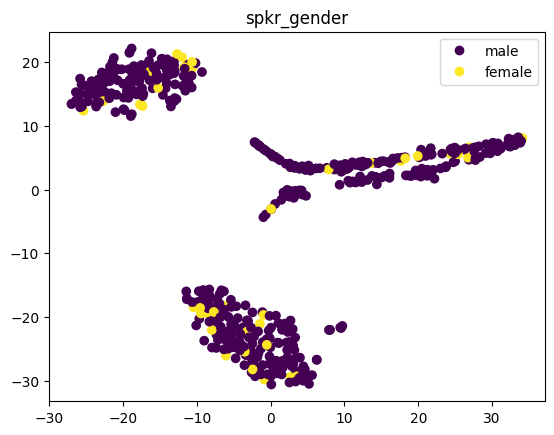

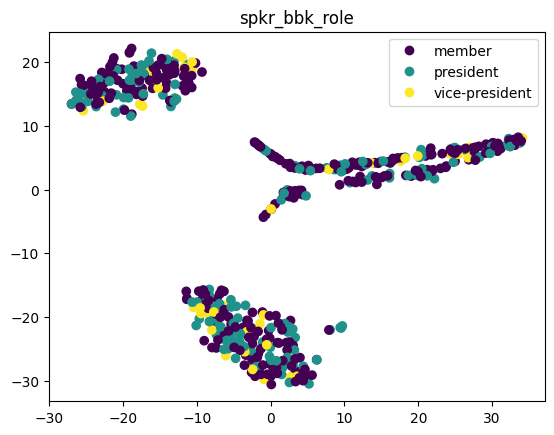

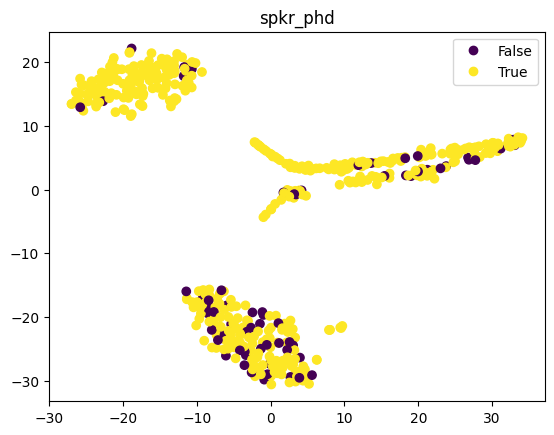

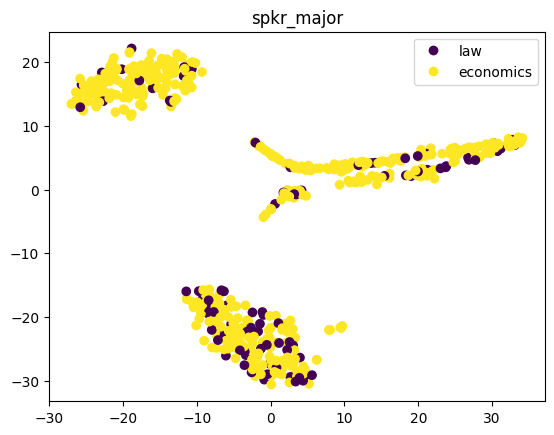

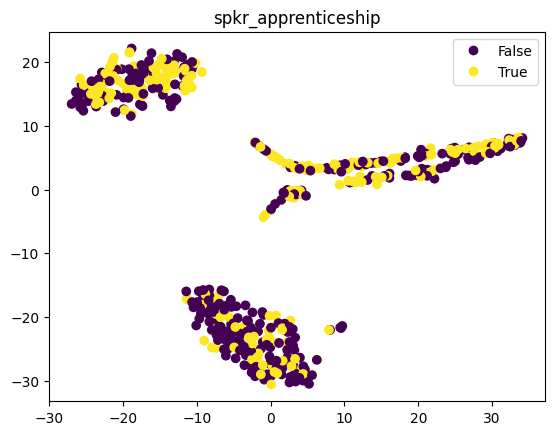

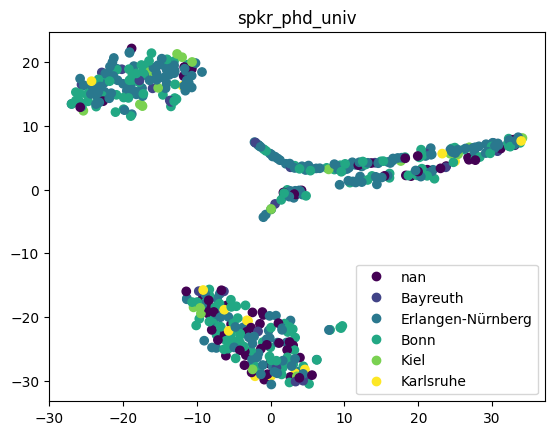

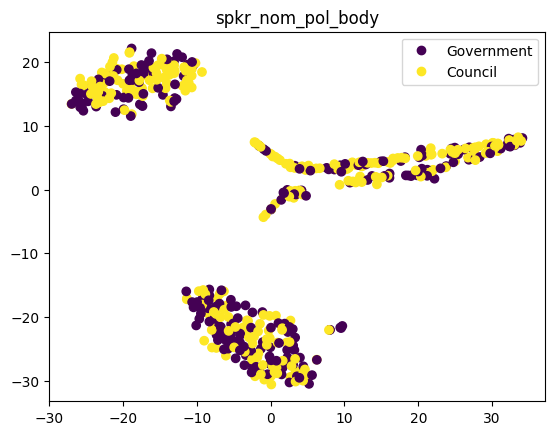

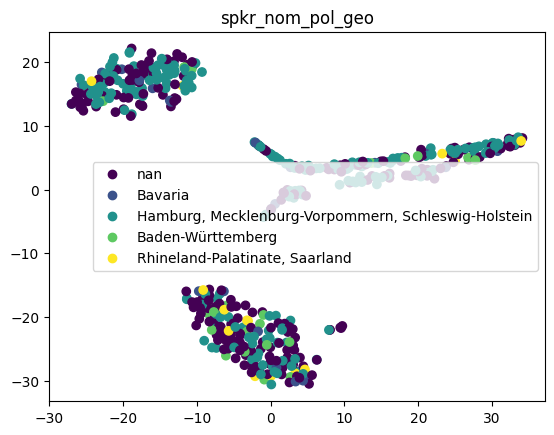

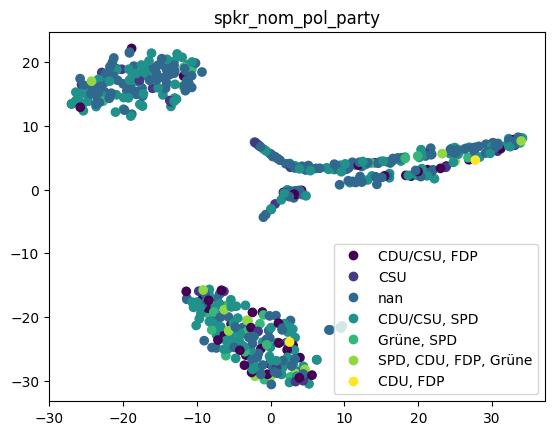

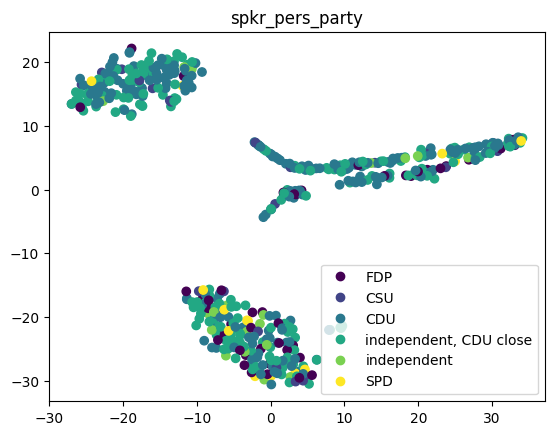

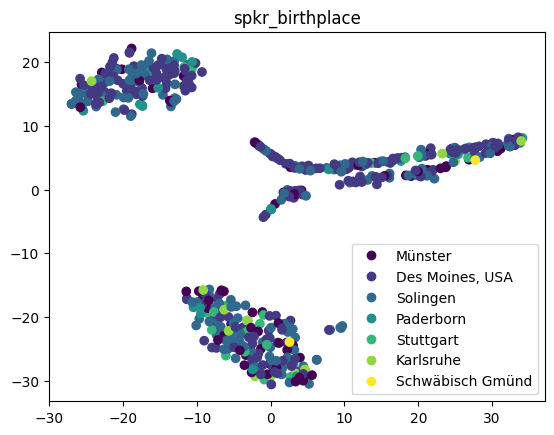

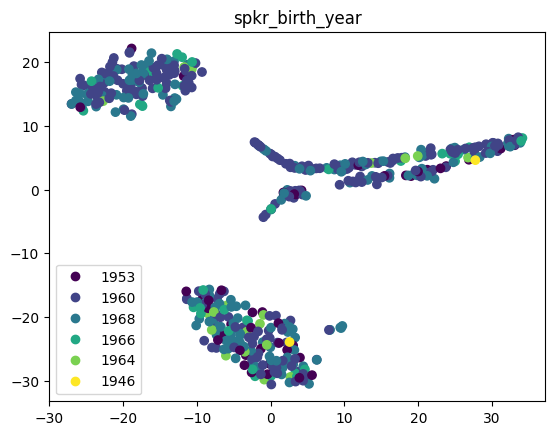

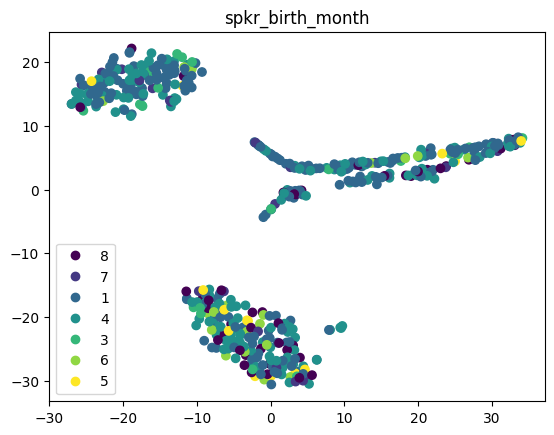

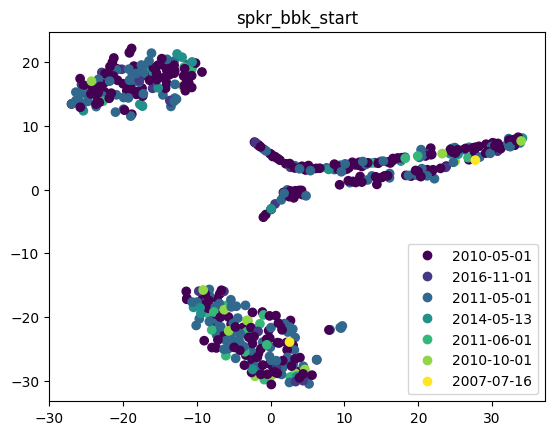

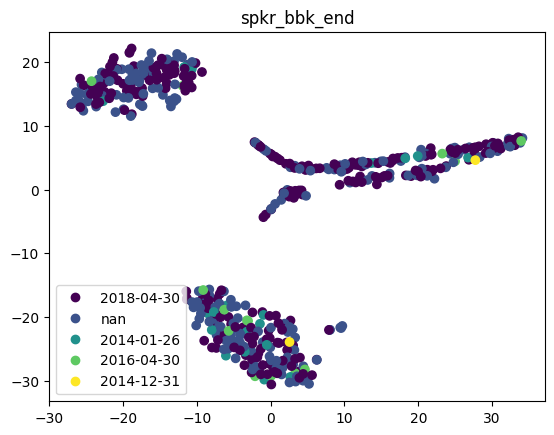

In [23]:
# Lets just take a look at all categorical dimensions to see if we find a pattern
# in the embedded space
# We are looking to see if can find any meaning in the clusters in the embedding

for class_col_name in df_speeches.columns:
    classifications = sample[class_col_name]
    if len(classifications.unique()) > 10 or len(classifications.unique()) <= 1:
        # too many unique values (or just a single one), it's not categorical
        continue

    # create an index from categories to colors
    colors = {
        classification: idx
        for idx, classification in enumerate(classifications.unique())
    }

    plot = plt.scatter(
        Xt[:, 0],  # first component of TSNE reduced embedding
        Xt[:, 1],  # second component of TSNE reduced embedding
        # use the correct color for each sample
        c=[colors[classification] for classification in classifications],
        label=classifications,
    )
    handles, _ = plot.legend_elements()
    plt.legend(handles, classifications.unique())
    plt.title(class_col_name)
    plt.show()